# Implementación de Modelos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz


# Utilidades pre-procesamiento, pipelines y automatización de entrenamiento
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    KFold, 
    StratifiedKFold, 
    GridSearchCV
    )

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

# Métricas de performance
from sklearn.metrics import (
    classification_report,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, auc,
    confusion_matrix
)

# Modelos
from src import TopKTabularMoE as tkm

from src.trainClassifiers import train_LogisticRegression # Custom LogisticRegression para evaluar en multiples tresholds.

# Diccionario con el grid de algoritmos y especificación de sus respectivos hiperparámetros
from src import benchmark_models


# Utilidades
import missingno as msno
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any, Union
import warnings
warnings.filterwarnings('ignore')

## Carga y Preprocesamiento de datos

In [2]:
# Importación de los datos
url = 'https://raw.githubusercontent.com/tuliorozco/applied-statistics/refs/heads/main/data/diabetes_dataset.csv'
data = pd.read_csv(url)
data.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [4]:
# =================================== PREPROCESAMIENTO ===================================

# Eliminación de observaciones duplicadas
data = data.drop_duplicates()
print(f"Nuevo total de registros: {len(data)}")
print(data.shape)

# 1. Separar las features predictoras (X) de la variable objetivo/target (y).
TARGET_COL = 'diabetes'
X = data.drop('diabetes', axis=1)
y = data[TARGET_COL]

# 2. Clasificar los campos por tipo de variable para el pre-procesamiento adecuado
numerical_cols = ["age", "bmi", "hbA1c_level", "blood_glucose_level"] 

binary_cols = ['race:AfricanAmerican','race:Asian','race:Caucasian',
               'race:Hispanic','race:Other','hypertension','heart_disease'] 


categorical_cols = [col for col in data.columns if col not in numerical_cols + binary_cols]
categorical_cols.remove('diabetes') 


# 3. División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)


# 4. Pre-procesamiento de los datos
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_cols),  
    ("num", StandardScaler(), numerical_cols),
    ("bin", "passthrough", binary_cols)  
])


Nuevo total de registros: 99986
(99986, 16)


## Metodología

### Especificación del Grid de Hiperparámetros por Tipo de Modelo

Teniendo en cuenta que los modelos a entrenar y analizar pueden ser ejecutados de forma automática mediante `GridSearchCV` (A excepción del algoritmo propuesto), se especificará un diccionario *models_config* estructurado de la siguiente forma:

* Key (clave): Identificación del tipo de algoritmo, ejemplo: KNN, LogisticRegresion, DecisionTree, etc.
* Value (valor): El conjunto de funciones (la implementación de cada algortimo en los paquetes `scikit-learn` o `xgboost`), los parámetros de inicialización del algoritmo (si los tiene) y sus respectivos hiperparámetros a evaluar en el entrenamiento. 

En la especificación se muestra de la siguiente manera:

```python
models_config = {
        'KNN': {
            'function': KNeighborsClassifier,
            'param_grid': {
            'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean']
            }   
        } ,
         'LogisticRegression': {
            'function': LogisticRegression,
            'init_params': {'max_iter': 1000, 'random_state': random_state}, 
            'param_grid': {
                'classifier__C': [0.01, 0.1, 1, 10, 100],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__solver': ['liblinear', 'saga']
            }
         },
    # Y así sucesivamente ...
    'MLP': {
        'function': MLPClassifier,
        'init_params': {
            'max_iter': 500,
            'random_state': 101
        },
        'param_grid': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__solver': ['adam', 'sgd'],
            'classifier__alpha': [0.0001, 0.001, 0.01]
        }
    }
}
```
Así mismo, se define una variable tipo `Dict` denominada *common_params* con las siguientes *key-values*:

* `X_train`: Variables predictoras del conjunto de entrenamiento.
* `X_test`: Variables predictoras del conjunto de test.
* `y_train`: Variable *target* del conjunto de entrenamiento.
* `y_test`: Variable *target* del conjunto de test.
* `cv_folds`: Número de pliegues para la validación cruzada (cross validation).
* `random_state`: Semilla de reproducibilidad.

### Entrenamiento: Algoritmos Clásicos

Definidos los algoritmos con sus respectivos hiperparámetros así como los parámetros comunes (conjuntos de entrenamiento y pruebas), se define un bucle *for* que recorrerá el diccionario y procesará cada algoritmo según lo especificado en *models_config*. Las métricas resultantes del entrenamiento se almacenarán en listas para el análisis comparativo posterior frente al modelo propuesto.

In [5]:
random_state = 101


# Parámetros comunes para el entrenamiento
common_params = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'cv_folds': 5,
    'random_state': random_state
}

In [ ]:
results_df, best_config_df, roc_curves = benchmark_models.run_benchmark(
    common_params=common_params,
    preprocessor=preprocessor,
    balance=False   # Sin aplicar remuestreo balanceado mediante SMOTE ni SMOTE-Tomek
)


Entrenando modelo: KNN
Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curves(roc_curves):
    """
    Grafica curvas ROC a partir del diccionario roc_curves.
    
    roc_curves : dict
        { modelo: (fpr, tpr, roc_auc) }
    """
    plt.figure(figsize=(16, 10))

    for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.3f})")

    # Línea diagonal de azar
    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Curvas ROC comparativas", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

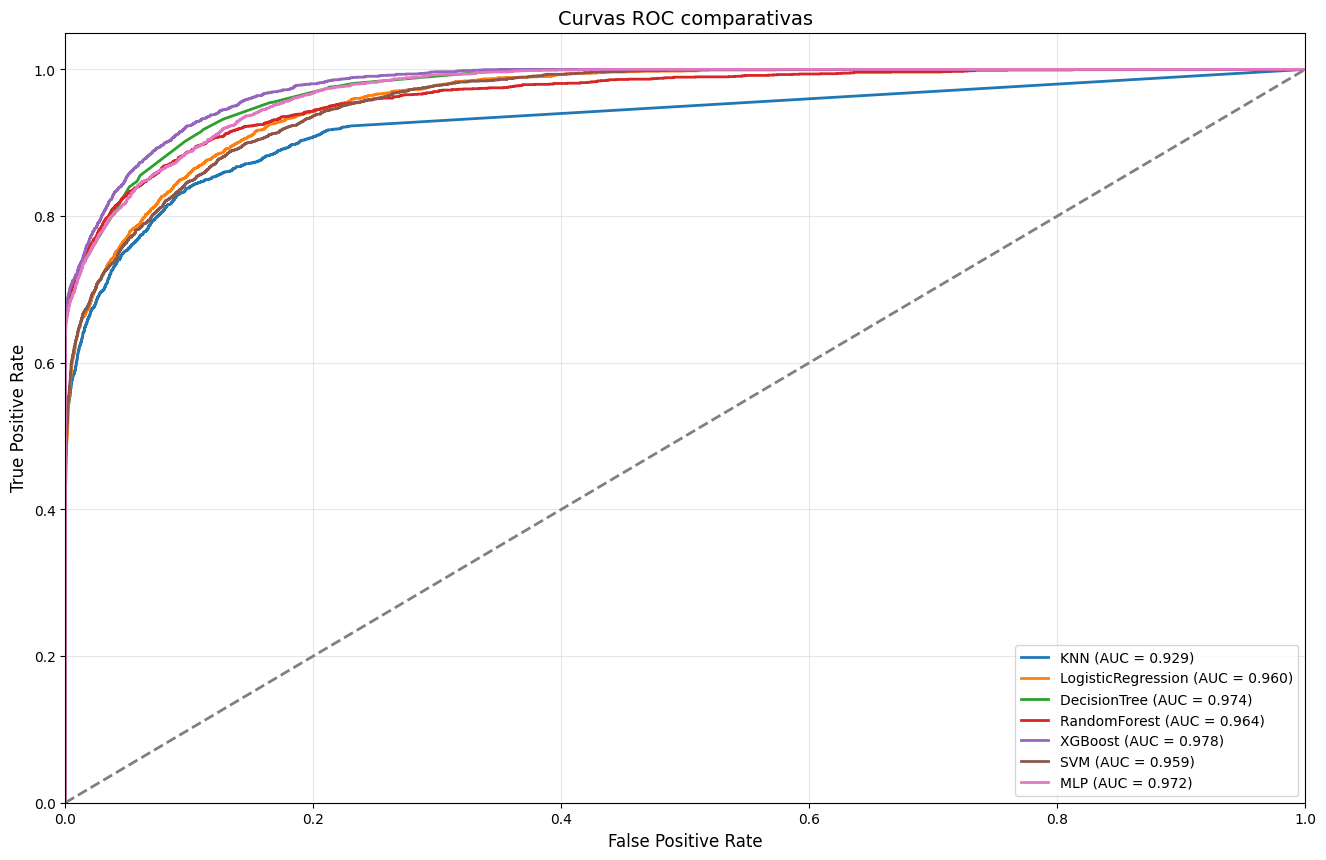

In [ ]:
plot_roc_curves(roc_curves)

La figura 1 presenta una comparativa de las curvas ROC-AUC de cada uno de los algoritmos de clasificación analizados. El eje X representa la tasa de falsos positivos (FPR), mientras que el eje Y muestra la tasa de verdaderos positivos (TPR). Los resultados reflejan un buen comportamiento general de los modelos, ya que todos presentan valores de AUC superiores a 0.92, lo que indica un alto poder predictivo. Sin embargo, algunos destacan sobre los demás:

* XGBoost → Es el modelo con mejor desempeño (AUC = 0.978), logrando la mayor capacidad de discriminación entre clases.
* Decision Tree (AUC = 0.974) y MLP (red neuronal) (AUC = 0.972) → También ofrecen resultados sobresalientes, muy cercanos al rendimiento de XGBoost.
* Random Forest (AUC = 0.964) y SVM (AUC = 0.959) → Mantienen una buena precisión y estabilidad en las predicciones.
* Logistic Regression (AUC = 0.960) → A pesar de ser un modelo más simple, logra un rendimiento competitivo.
* KNN (AUC = 0.929) → Presenta el valor más bajo dentro del conjunto, pero aun así mantiene un desempeño aceptable.
En síntesis, el modelo XGBoost se posiciona como la mejor alternativa para la clasificación de pacientes con y sin diabetes, seguido muy de cerca por Decision Tree y MLP. Estos resultados evidencian que los modelos basados en aprendizaje no lineal y técnicas avanzadas de ensamble ofrecen mayor precisión y confiabilidad para este problema.  

## Resultados y *Benchmark*

In [ ]:
# =================================== METRICAS EN FORMATO TABULAR ===================================


# Agrupar por métrica y seleccionar el índice del máximo en la columna 'Valor'
idx = best_config_df.groupby("Métrica")["Valor"].idxmax()

# Filtrar el DataFrame con esos índices
best_overall_df = best_config_df.loc[idx].reset_index(drop=True)

In [ ]:
print("\n" + "="*100)
print(" "*35 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
results_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})


                                   TABLA COMPARATIVA DE RESULTADOS


Model,Precision,Recall,F1-Score,Accuracy,ROC-AUC,Best Params,TN,TP,FP,FN
KNN,0.987,0.522,0.683,0.959,0.929,"{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}",27428,1331,18,1219
LogisticRegression,0.875,0.628,0.732,0.961,0.960,"{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}",27218,1602,228,948
DecisionTree,0.974,0.676,0.798,0.971,0.974,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}",27400,1724,46,826
RandomForest,0.998,0.666,0.799,0.972,0.964,"{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}",27443,1699,3,851
XGBoost,0.985,0.677,0.803,0.972,0.978,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",27420,1727,26,823
SVM,0.922,0.597,0.725,0.961,0.959,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",27318,1522,128,1028
MLP,0.930,0.687,0.790,0.969,0.972,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}",27314,1752,132,798


In [ ]:
print("\n" + "="*100)
print(" "*35 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
best_overall_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})


                                   TABLA COMPARATIVA DE RESULTADOS


Modelo,Métrica,Valor,Parámetros
XGBoost,Accuracy,0.971696,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
XGBoost,F1-Score,0.802696,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
RandomForest,Precision,0.998237,"{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}"
XGBoost,ROC-AUC,0.978170,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
MLP,Recall,0.687059,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}"


In [ ]:
# Entreaniemto de modelo con algoritmo de Regresión Logística y evaluación con thresholds entre 0.30 y 0.48

# Definición de umbrales para la evaluación.
thresholds = [round(0.30 + i *0.02, 2) for i in range(10)]

results_lr_df, best_configs_lr = train_LogisticRegression(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    preprocessor=preprocessor,
    thresholds=thresholds,
    param_grid={
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    cv_folds=5,
    max_iter=1000,
    random_state=101
)

In [ ]:
results_lr_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})

Threshold,Precision,Recall,F1-Score,Accuracy,ROC-AUC,Best Params,TN,TP,FP,FN
0.300000,0.714,0.709,0.712,0.951,0.961,C: 0.1,26723,1808,723,742
0.320000,0.734,0.696,0.714,0.953,0.961,C: 0.1,26802,1774,644,776
0.340000,0.751,0.685,0.717,0.954,0.961,C: 0.1,26868,1747,578,803
0.360000,0.768,0.678,0.720,0.955,0.961,C: 0.1,26924,1728,522,822
0.380000,0.784,0.668,0.721,0.956,0.961,C: 0.1,26976,1704,470,846
0.400000,0.804,0.663,0.727,0.958,0.961,C: 0.1,27035,1690,411,860
0.420000,0.820,0.656,0.729,0.959,0.961,C: 0.1,27079,1673,367,877
0.440000,0.836,0.649,0.731,0.959,0.961,C: 0.1,27122,1654,324,896
0.460000,0.851,0.639,0.730,0.960,0.961,C: 0.1,27160,1630,286,920
0.480000,0.862,0.633,0.730,0.960,0.961,C: 0.1,27188,1614,258,936


In [ ]:
best_configs_lr.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})

Métrica,Mejor Threshold,Valor,Parámetros
Precision,0.480000,0.862179,C: 0.1
Recall,0.300000,0.709020,C: 0.1
F1-Score,0.440000,0.730565,C: 0.1
Accuracy,0.480000,0.960195,C: 0.1
ROC-AUC,0.300000,0.960556,C: 0.1


In [6]:
results_balanced_df, best_config_balanced_df, roc_curves_balanced = benchmark_models.run_benchmark(
    common_params=common_params,
    preprocessor=preprocessor,
    balance=True,   # Sin aplicar remuestreo balanceado mediante SMOTE ni SMOTE-Tomek
    method="smote_tomek",
    sampling_strategy=15000
)


Entrenando modelo: KNN
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Entrenamiento completado. Tiempo entrenamiento KNN: 459.6583 segundos

Entrenando modelo: LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Entrenamiento completado. Tiempo entrenamiento LogisticRegression: 139.6412 segundos

Entrenando modelo: DecisionTree
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Entrenamiento completado. Tiempo entrenamiento DecisionTree: 12.7919 segundos

Entrenando modelo: RandomForest
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Entrenamiento completado. Tiempo entrenamiento RandomForest: 378.7573 segundos

Entrenando modelo: XGBoost
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Entrenamiento completado. Tiempo entrenamiento XGBoost: 74.3946 segundos

Entrenando modelo: SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Entrenamiento completado. Tiempo entrenamiento SVM: 4379.8907 se

---

Construcción del modelo:

In [6]:
print("\nTamaños:")
print(f"Train:{X_train.shape}")
# print(f"Calibración:{X_cal.shape}")
print(f"Test:{X_test.shape}")

# Definir vocabularios para categóricas
cat_vocab_sizes = {col: data[col].nunique() for col in categorical_cols}
print(f"\nVocabulario variables categóricas = {cat_vocab_sizes}")


Tamaños:
Train:(69990, 15)
Test:(29996, 15)

Vocabulario variables categóricas = {'year': 7, 'gender': 3, 'location': 55, 'smoking_history': 6}


---

Preprocesamiento de los datos para el entrenamiento:

In [7]:
# --------------------- PREPROCESAMIENTO PARA TopKTabularMoE -------------------------------


from sklearn.preprocessing import OrdinalEncoder

# por si en el futuro aparecen categorías no vistas en el entrenamiento.
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# 2. Ajustar el codificador SOLO con los datos de entrenamiento (X_train)
#    y transformar X_train.
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])

#  Transformar X_test usando el encoder YA AJUSTADO. Es crucial no volver a hacer 'fit'.
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols]) # <-- Paso crucial para X_test


# Crear el DataFrame de entrenamiento completo
train_df = X_train.copy()
train_df[TARGET_COL] = y_train

# DataFrame para la función evaluate
test_df = X_test.copy()
test_df[TARGET_COL] = y_test # <-- Re-unimos X_test con y_test

print("Preprocesamiento terminado.")

Preprocesamiento terminado.


---

Especificación del modelo SparseTabularMoE:

In [8]:
from src import spartan
import tensorflow as tf

# --- 2. Configuración de Estrategia Distribuida ---
strategy = tf.distribute.MirroredStrategy()
print(f'Estrategia distribuida activada. Dispositivos: {strategy.num_replicas_in_sync}')

d_model = 128

# Parámetros para construir la arquitectura del modelo
model_params = {
    'cont_cols': numerical_cols,
    'bin_cols': binary_cols,
    'cat_cols': categorical_cols,
    'cat_vocab_sizes': cat_vocab_sizes,
    'd_model': d_model,
    'num_heads': 4,
    'd_ff': 4 * d_model,
    'num_experts': 4,
    'num_layers': 2,
    'dropout': 0.1,
    'k': 2
}

# Parámetros para el proceso de entrenamiento
training_params = {
    'lr': 3e-4,
    'epochs': 30, # Puedes reducir las épocas para una CV más rápida
    'batch_size': 256 * strategy.num_replicas_in_sync,
    'target_col': TARGET_COL,
    'col_groups': { # Agrupamos las listas de columnas
        'cont_cols': numerical_cols,
        'bin_cols': binary_cols,
        'cat_cols': categorical_cols,
        'target_col': TARGET_COL
    }
}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Estrategia distribuida activada. Dispositivos: 1


------

Entrenamiento del modelo:

In [10]:
from src import spartan
from src.spartan import cross_validation as cv
# --- 4. Ejecutar la Validación Cruzada ---
# Una sola llamada a la función orquesta todo el proceso.
best_model, cv_results = cv.run_cross_validation(
    df_full_train=train_df, # Usando el DataFrame de entrenamiento completo
    target_col=TARGET_COL,
    strategy=strategy,
    model_build_params=model_params,
    training_params=training_params,
    n_splits=5, # Número de folds
    apply_smote=False, # No se aplica muestreo balanceado
    thresholds=[0.3, 0.35, 0.4, 0.45, 0.5]
)

print("\nAnálisis detallado por fold:")
print(cv_results)

Iniciando validación cruzada con 5 folds...
--------------------------------------------------
--- FOLD 1/5 ---
--------------------------------------------------
Fold 1: No se aplicará remuestreo.
Fold 1: Construyendo y compilando un nuevo modelo...
Convirtiendo DataFrames a tensores para el entrenamiento...
Creando datasets de TensorFlow...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job

Calibrar conformal (split-conformal sobre cal_df):

In [27]:
# --- 3. División y Procesamiento de Datos ---

# Dividir el conjunto train en entrenamiento (80%) y calibración (20%) para la calibración.
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)

# 2. Ajustar el codificador SOLO con los datos de entrenamiento (X_train)
#    y transformar X_train.
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])

#  Transformar X_cal y X_test usando el encoder YA AJUSTADO. Es crucial no volver a hacer 'fit'.
X_cal[categorical_cols] = encoder.transform(X_cal[categorical_cols])



# Crear el DataFrame de entrenamiento completo
train_df = X_train.copy()
train_df[TARGET_COL] = y_train

# Crear el DataFrame de calibración completo
cal_df = X_cal.copy()
cal_df[TARGET_COL] = y_cal

print("Tamaños:")
print(f"Train:{X_train.shape}")
print(f"Calibración:{X_cal.shape}")

Tamaños:
Train:(48993, 15)
Calibración:(20997, 15)


In [28]:
from src.spartan import conformal
# --- PASO 4: CALIBRACIÓN CONFORMAL ---

# Usar el conjunto de calibración para encontrar un umbral de decisión con garantías estadísticas.
print("\nPaso 4: Realizando la calibración conformal...")
ALPHA = 0.1 # Nivel de error aceptable (queremos un 90% de confianza)

# 1. Recibe el diccionario completo en una sola variable
qhat_dict = conformal.calibrate_conformal_conditional(
    model=best_model,
    df_cal=cal_df,
    cont_cols=numerical_cols,
    bin_cols=binary_cols,
    cat_cols=categorical_cols,
    target_col=TARGET_COL,
    alpha=ALPHA
)

# 2. Extrae los valores numéricos del diccionario
qhat_0 = qhat_dict["qhat_0"]
qhat_1 = qhat_dict["qhat_1"]

# 3. Ahora puedes imprimir los valores numéricos correctamente
print(f"Nivel de error alpha: {ALPHA}")
print(f"Cuantil para la clase negativa (qhat_0): {qhat_0:.4f}")
print(f"Cuantil para la clase positiva (qhat_1): {qhat_1:.4f}")

# Opcional: Calcula y muestra los umbrales de decisión finales
# según la documentación de tu propia función
umbral_decision_negativo = qhat_0
umbral_decision_positivo = 1 - qhat_1

print("-" * 30)
print(f"Umbral de decisión para clase negativa (p <= qhat_0): {umbral_decision_negativo:.4f}")
print(f"Umbral de decisión para clase positiva (p >= 1 - qhat_1): {umbral_decision_positivo:.4f}")



Paso 4: Realizando la calibración conformal...
Nivel de error alpha: 0.1
Cuantil para la clase negativa (qhat_0): 0.1751
Cuantil para la clase positiva (qhat_1): 0.8168
------------------------------
Umbral de decisión para clase negativa (p <= qhat_0): 0.1751
Umbral de decisión para clase positiva (p >= 1 - qhat_1): 0.1832


Evaluar en el conjunto test:

In [30]:
# --- PASO 5: EVALUACIÓN FINAL EN EL CONJUNTO DE PRUEBA ---
# Evaluar el rendimiento del modelo en datos nunca antes vistos.
print("\nPaso 5: Evaluando el modelo en el conjunto de prueba...")
# Primero, preparamos el df_test completo
df_test = X_test.copy()
df_test[TARGET_COL] = y_test


print("Tamaño dataset test:")
print(f"Train:{X_test.shape}")

# Evaluar con el umbral estándar de 0.5 como línea base
print("\n--- Evaluación con umbral estándar de 0.5 ---")
conformal_metrics = conformal.evaluate_conformal_sets(
    model=best_model,
    df_test=df_test,
    cont_cols=numerical_cols,
    bin_cols=binary_cols,
    cat_cols=categorical_cols,
    target_col=TARGET_COL,
    qhats=qhat_dict
)
print(conformal_metrics)


Paso 5: Evaluando el modelo en el conjunto de prueba...
Tamaño dataset test:
Train:(29996, 15)

--- Evaluación con umbral estándar de 0.5 ---
{'coverage': 0.8932190958794506, 'average_set_size': 0.9879650620082677}


# Evaluación de Métricas de Performance

In [7]:
print("\n" + "="*100)
print(" "*35 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
results_balanced_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})


                                   TABLA COMPARATIVA DE RESULTADOS


Model,Precision,Recall,F1-Score,Accuracy,ROC-AUC,Best Params,TN,TP,FP,FN
KNN,0.987,0.522,0.683,0.959,0.929,"{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}",27428,1331,18,1219
LogisticRegression,0.875,0.628,0.732,0.961,0.960,"{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}",27218,1602,228,948
DecisionTree,0.972,0.676,0.798,0.971,0.974,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}",27397,1725,49,825
RandomForest,0.998,0.667,0.799,0.972,0.964,"{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}",27443,1700,3,850
XGBoost,0.985,0.677,0.803,0.972,0.978,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}",27420,1727,26,823
SVM,0.922,0.597,0.725,0.961,0.959,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",27318,1522,128,1028
MLP,0.963,0.678,0.796,0.970,0.971,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}",27380,1728,66,822


In [8]:
# Agrupar por métrica y seleccionar el índice del máximo en la columna 'Valor'
idx = best_config_balanced_df.groupby("Métrica")["Valor"].idxmax()

# Filtrar el DataFrame con esos índices
best_overall_balanced_df = best_config_balanced_df.loc[idx].reset_index(drop=True)

print("\n" + "="*100)
print(" "*35 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*100)
best_overall_balanced_df.style.hide(axis="index").format({
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "Accuracy": "{:.3f}",
    "ROC-AUC": "{:.3f}"
})


                                   TABLA COMPARATIVA DE RESULTADOS


Modelo,Métrica,Valor,Parámetros
XGBoost,Accuracy,0.971696,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
XGBoost,F1-Score,0.802696,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
RandomForest,Precision,0.998238,"{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}"
XGBoost,ROC-AUC,0.978170,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}"
MLP,Recall,0.677647,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}"
